# Praktikum 1

## Setup

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [18]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'The first thing I thought when I saw this films was: It is not really a film, at least it is not what we imagine spontaneously when we hear the word "film". it is entirely symbolic, everything in it has a figurative meaning. So if you are not used to express thing in a symbolic way, you will find it strange, if you are not acquainted with philosophy, religion, spiritual life, you will think it\'s just a fairy-tale... and even a weird one, chaotic. For me "The legend of Zu" is perfectly transparent. And I do like it. It tells us in images the story about the fight between light and darkness, the fight that is as old as humanity, and every one who is in search of the sens in this life is confronted with it. The film is obviously made by Buddhists. I am not a Buddhist. My religion and the vision of the world and human is different. But as far as we are all humans and have the same human nature we necessarily have common experiences and can understand each other. It is a really 

## Buat Teks Encoder

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[  2,  86, 151, ...,   0,   0,   0],
       [  9,  96,  26, ...,   0,   0,   0],
       [ 10, 116,   4, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The first thing I thought when I saw this films was: It is not really a film, at least it is not what we imagine spontaneously when we hear the word "film". it is entirely symbolic, everything in it has a figurative meaning. So if you are not used to express thing in a symbolic way, you will find it strange, if you are not acquainted with philosophy, religion, spiritual life, you will think it\'s just a fairy-tale... and even a weird one, chaotic. For me "The legend of Zu" is perfectly transparent. And I do like it. It tells us in images the story about the fight between light and darkness, the fight that is as old as humanity, and every one who is in search of the sens in this life is confronted with it. The film is obviously made by Buddhists. I am not a Buddhist. My religion and the vision of the world and human is different. But as far as we are all humans and have the same human nature we necessarily have common experiences and can understand each other. It is a reall

## Buat Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.01167258]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 63ms/step
[0.01167258]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [15]:
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 52s 105ms/step - loss: 0.6421 - accuracy: 0.5656 - val_loss: 0.4965 - val_accuracy: 0.7458
Epoch 2/10
391/391 [==============================] - 25s 64ms/step - loss: 0.4000 - accuracy: 0.8168 - val_loss: 0.3652 - val_accuracy: 0.8464
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3393 - accuracy: 0.8505 - val_loss: 0.3423 - val_accuracy: 0.8401
Epoch 4/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3234 - accuracy: 0.8592 - val_loss: 0.3294 - val_accuracy: 0.8490
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3193 - accuracy: 0.8600 - val_loss: 0.3268 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3099 - accuracy: 0.8663 - val_loss: 0.3300 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3066 - accuracy: 0.8688 - val_loss: 0.3231 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3271 - accuracy: 0.8408
Test Loss: 0.3270973861217499
Test Accuracy: 0.8408399820327759


(0.0, 0.6592221230268478)

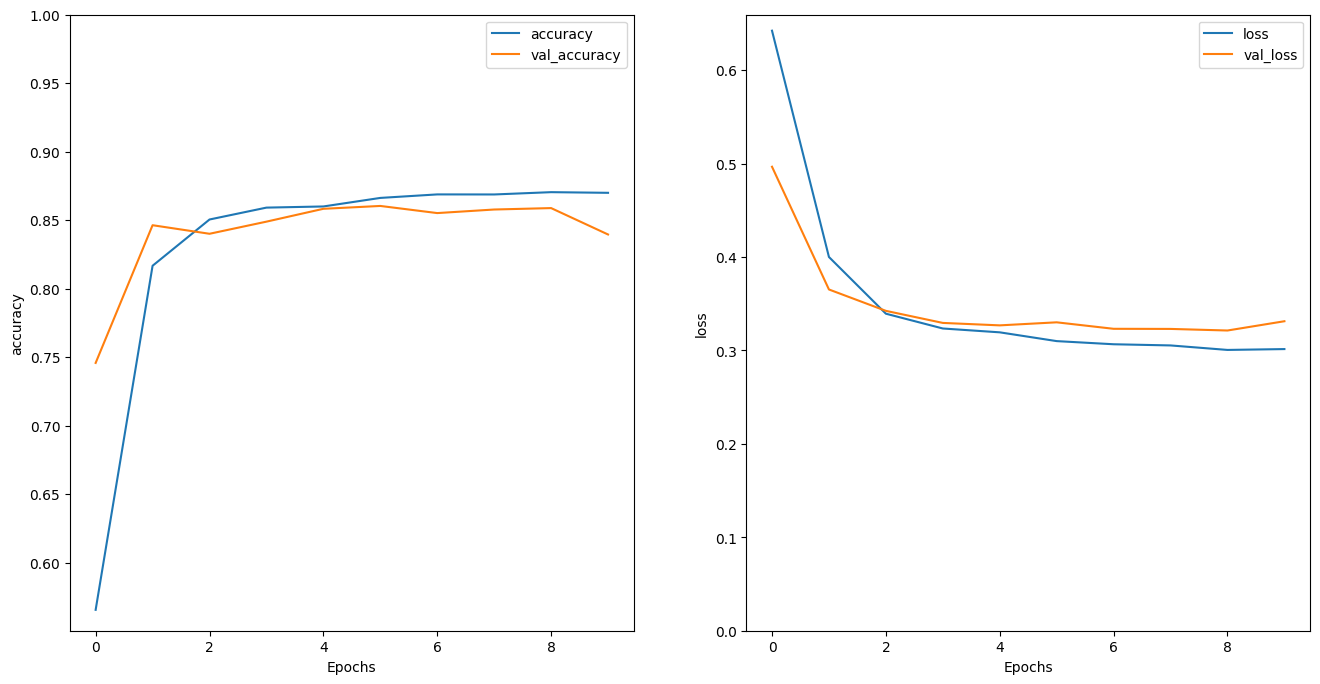

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


## Stack two or more LSTM layers

In [21]:
model = tf.keras.Sequential([encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [28]:
history = model.fit(train_dataset, epochs=10,
validation_data=test_dataset,
validation_steps=30)

Epoch 1/10
391/391 [==============================] - 53s 135ms/step - loss: 0.2932 - accuracy: 0.8723 - val_loss: 0.3186 - val_accuracy: 0.8474
Epoch 2/10
391/391 [==============================] - 49s 125ms/step - loss: 0.2909 - accuracy: 0.8742 - val_loss: 0.3178 - val_accuracy: 0.8578
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.2856 - accuracy: 0.8762 - val_loss: 0.3182 - val_accuracy: 0.8516
Epoch 4/10
391/391 [==============================] - 46s 118ms/step - loss: 0.2862 - accuracy: 0.8775 - val_loss: 0.3225 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 46s 115ms/step - loss: 0.2822 - accuracy: 0.8784 - val_loss: 0.3330 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 46s 117ms/step - loss: 0.2825 - accuracy: 0.8768 - val_loss: 0.3254 - val_accuracy: 0.8438
Epoch 7/10
391/391 [==============================] - 46s 117ms/step - loss: 0.2781 - accuracy: 0.8778 - val_loss: 0.3363 - val_ac

In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 46ms/step - loss: 0.3503 - accuracy: 0.8597
Test Loss: 0.35032370686531067
Test Accuracy: 0.85971999168396


In [33]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 23ms/step
[[-1.8977195]]


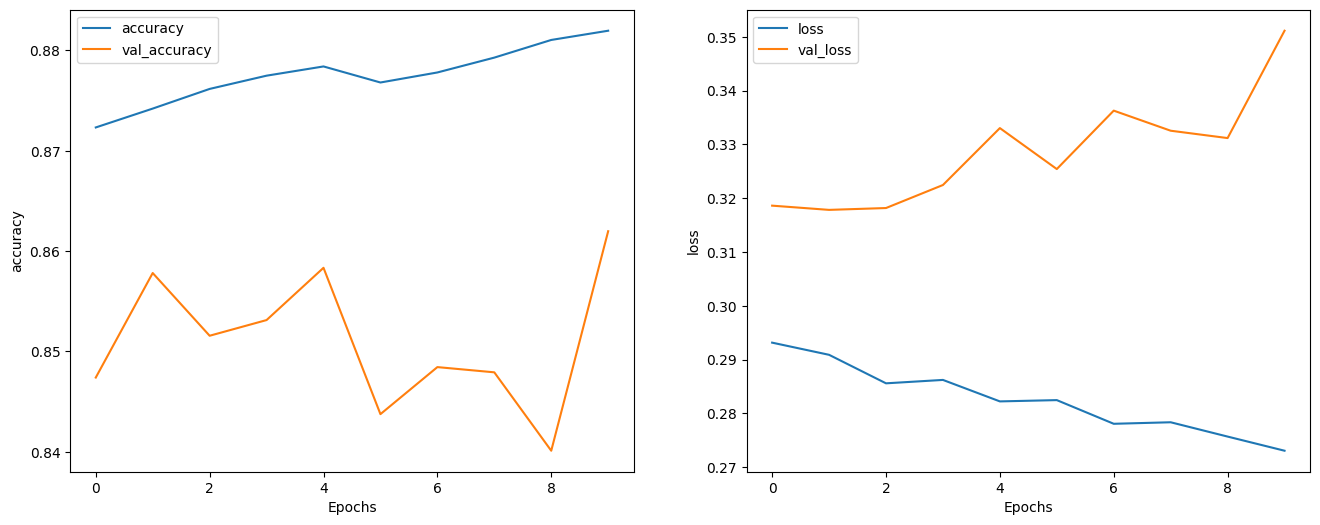

In [32]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')